# Model Pipeline

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit,minimize
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
import json 
import os

warnings.filterwarnings('ignore')
sns.set_palette('Blues_r')

## Load Datasets

In [3]:
daily_data = pd.read_csv('./Data/daily_data.csv')
daily_data.drop('Unnamed: 0', axis = 1,inplace=True)
monthly_data = pd.read_csv('./Data/monthly_dataset.csv')

## Apply MMM Model

### Functions

In [4]:
# Michaelis-Menten model
def mmequation(X,*alphas):
    n_features = X.shape[1]
    result = np.zeros(X.shape[0])
    # Sum contributions from all features
    for i in range(n_features):
        feature_values = X[:, i]
        result += (alphas[i] * feature_values)/(1 + feature_values)
    return result


In [5]:
# Train the model
def fit_to_data(x_data, y_data,iter = 1000000,components=None):
    if components is None:
        components = x_data.shape[1]
    if x_data.ndim == 1:
        x_data = x_data.reshape(-1, 1)

    # Initial parameter guess
    initial_guess = ([1] * (components))

    # Set bounds: all parameters must be positive
    bounds_lower = [0] * (components)
    bounds_upper = [np.inf] * (components)

    # Fit the model
    alphas,_ = curve_fit(
        mmequation,
        x_data,
        y_data,
        p0=initial_guess,
        bounds=(bounds_lower, bounds_upper),
        maxfev=iter
    )
    
    return alphas

In [6]:
# Visualization function to see the fit
def plot_model_fit(x_data, y_data, alphas):
    y_pred = mmequation(x_data, *alphas)

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_data)), y_data, color='blue', label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted')
    plt.legend()
    plt.title('Michaelis-Menten Model Fit')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    n_features = x_data.shape[1]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(n_features), alphas)
    plt.title('Values (Saturation Levels)')
    plt.xlabel('Feature Index')
    plt.tight_layout()
    plt.show()

In [7]:
# Check the accuracy of the model
def validate_model_parameters(x_data, y_data, alphas):
    y_pred = mmequation(x_data, *alphas)
    r2 = r2_score(y_data, y_pred)
    residuals = y_data - y_pred

    validation_results = {
        'r2': r2,
        'residuals': residuals,
        'predictions': y_pred
    }
    
    return validation_results

In [8]:
# Defines the Linear Programming Problem
def objective_function(x, a):
    return -np.sum(((a * x)/(1 + x)))

def constraint_sum_to_one(x):
    return np.sum(x) - (monthly_data['gmv'].values[-1]/1e7)

def optimize_log_sum_with_constraint(a, x0=None):
    """
    Find x_i values that maximize Σ a_i log(x_i) subject to:
    - 0 ≤ x_i ≤ k for all i
    - Σ x_i = l
    """
    n = len(a)

    # Set initial feasible values if not provided
    if x0 is None:
        x0 = np.ones(n) / n

    # Define bounds: 0 ≤ x_i ≤ k for all i
    bounds = [(0, a[i]/1e7) for i in range(n)]

    # Define the sum constraint: Σ x_i = l
    constraint = {
        'type': 'eq',
        'fun': constraint_sum_to_one
    }

    # Perform the optimization
    result = minimize(
        objective_function,
        x0,
        args=(a,),
        bounds=bounds,
        constraints=[constraint],
        method='SLSQP'
    )

    return result

In [9]:
# Visualize the relationship between coefficients and optimal values
def visualize_results(a, x_optimal):
    plt.figure(figsize=(10, 6))
    indices = np.arange(len(a))

    plt.subplot(2, 1, 1)
    plt.bar(indices, a , color='skyblue')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Coefficients (a_i)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.bar(indices, x_optimal, color='lightgreen')
    plt.title('Optimal Allocation (x_i)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [10]:
def MMModel(product,target = 'gmv',debug=False):
   # Creates a monthly dataset for the product category
   data = daily_data[daily_data['product_analytic_category'] == product]
   data.drop(['fsn_id','product_analytic_category','order_id','order_item_id','cust_id','Occassion'],axis=1,inplace=True)

   data['order_date'] = pd.DatetimeIndex(data['order_date'])
   df = data.resample('M',on='order_date')[['gmv', 'units']].sum()
   monthly = monthly_data.set_index('Unnamed: 0')
   monthly.index = pd.DatetimeIndex(df.index)
   
   df = pd.concat([df,monthly[['Total Investment', 'TV',
      'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing',
      ' Affiliates', 'SEM', 'Radio', 'Other']]],axis=1)
   df['Others'] = df['Other'] + df['Radio'] + df['SEM']
   df.drop(['SEM', 'Radio', 'Other'],axis=1,inplace=True)

   filtered = df[[target,'TV', 'Digital','Sponsorship', 'Content Marketing', 'Online marketing', ' Affiliates', 'Others']]
   
   model_params = fit_to_data(filtered.drop(target,axis=1).values,df[target].values,components=filtered.shape[1] -1)
   val =  validate_model_parameters(filtered.drop(target,axis=1).values,df[target].values, model_params)
   
   if debug:
      print("Parameters (saturation levels):")
      for i, alpha in enumerate(model_params):
            print(f"Coefficent of {filtered.columns[i+1]}: {alpha:.4f}")
            print("="*60)

      plot_model_fit(filtered.drop(target,axis=1).values,df[target].values, model_params)

      print(f"R2 obtained is: {val['r2']}")
      print(f"Sum of coefficients: {np.sum(model_params)}")
      print("="*60)

      result = optimize_log_sum_with_constraint(model_params)
      print("\nOptimization Results:")
      print("Success:", result.success)
      print("Message:", result.message)
      print("Optimal x values:", result.x)
      print("Sum of x values:", np.sum(result.x))
      print("\nDetailed breakdown:")
      for i, (coef, value) in enumerate(zip(a, result.x)):
         contribution = coef * np.log(max(value, 1e-10))
         print(f"{filtered.columns[i+1]}: {value:.6f} (coef={coef:+.2f}, contribution={contribution:.6f})")
    
   return model_params,val['r2']

### Calculation

In [11]:
final_g = []
final_u = []
r2_g = []
r2_u = []

for p in daily_data['product_analytic_category'].unique():
    model_params,r2 = MMModel(p,'gmv')
    final_g.append(model_params)
    r2_g.append(r2)
    
for p in daily_data['product_analytic_category'].unique():
    model_params,r2 = MMModel(p,'units')
    final_u.append(model_params)
    r2_u.append(r2)

a = [p for p in daily_data['product_analytic_category'].unique()]
weights_u = dict(zip(a, final_u))
weights_g = dict(zip(a, final_g))

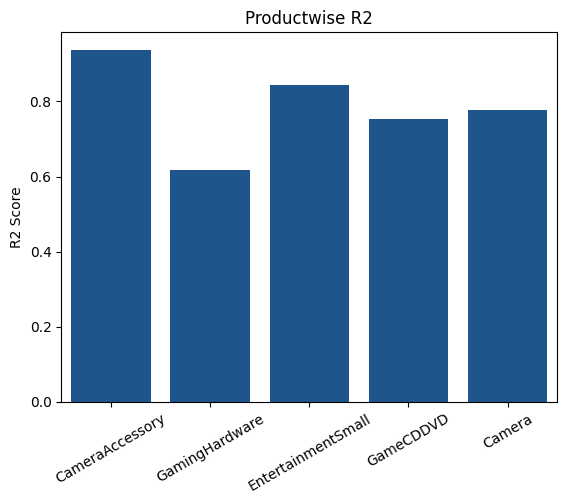

In [12]:
sns.barplot(x = daily_data['product_analytic_category'].unique() , y = r2_g)
plt.ylabel('R2 Score')
plt.xticks(rotation=30)
plt.title('Productwise R2')
plt.show()

## Final Optimization
    incorporating SDPI and product weights

In [13]:
# SDPI goes here and so does the product weights

In [14]:
#product weights
cat_gmv = []
cat_units = []

for cat in a:
    cat_gmv.append(daily_data[daily_data['product_analytic_category'] == cat]['gmv'].sum())
    cat_units.append(daily_data[daily_data['product_analytic_category'] == cat]['units'].sum())

sum_gmv = [5*x/sum(cat_gmv) for x in cat_gmv]
sum_units = [5*x/sum(cat_units) for x in cat_units]
prod_weights_g = {}
prod_weights_u= {}
for count, cat in enumerate(a):
    prod_weights_g[cat] = sum_gmv[count]
    prod_weights_u[cat] = sum_units[count]

In [15]:
# --- New Objective Function ---
def objective_function(x, A):
    total = 0.0
    for i in range(len(x)):
        total += A[i]*x[i] / (1 + x[i])
    return -total

def constraint_sum_to_one(x):
    return np.sum(x) - monthly_data['gmv'].values[-1]/1e6

def optimize_allocation(A, x0=None,iter = 1000000):
    n = len(A)
    if x0 is None:
        x0 = np.ones(n) / n 

    bounds = [(0, A[i]/1e7) for i in range(n)]

    result = minimize(objective_function,x0,args=(A,),bounds=bounds,method='SLSQP',options={'maxiter': iter})
    return result
#

In [16]:
# --- Visualization Function ---
def visualize_results(A, x_optimal):
    indices = np.arange(1, len(A)+1)
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.bar(indices, A, color='skyblue')
    plt.title('Aggregated Coefficients (A)')
    plt.xlabel('Channel Index')
    plt.ylabel('Aggregated Alpha')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.bar(indices, x_optimal, color='lightgreen')
    plt.title('Optimal Allocation (x)')
    plt.xlabel('Channel Index')
    plt.ylabel('Allocation')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



Final Optimization Results:
Success: True
Message: Optimization terminated successfully
Optimal x values: [6.99185180e-01 3.75683973e+00 4.81115913e-02 7.35501986e+00
 9.51611074e+00 6.30292419e+00 1.57483853e-06]
Sum of x values: 27.678192862585373
Maximum value of the function: 23.782741313135237

Detailed breakdown:
x_1: 0.699185 (Aggregated Coefficient A_1 = 6.99e+06)
x_2: 3.756840 (Aggregated Coefficient A_2 = 3.76e+07)
x_3: 0.048112 (Aggregated Coefficient A_3 = 4.81e+05)
x_4: 7.355020 (Aggregated Coefficient A_4 = 7.36e+07)
x_5: 9.516111 (Aggregated Coefficient A_5 = 9.52e+07)
x_6: 6.302924 (Aggregated Coefficient A_6 = 6.30e+07)
x_7: 0.000002 (Aggregated Coefficient A_7 = 1.57e+01)


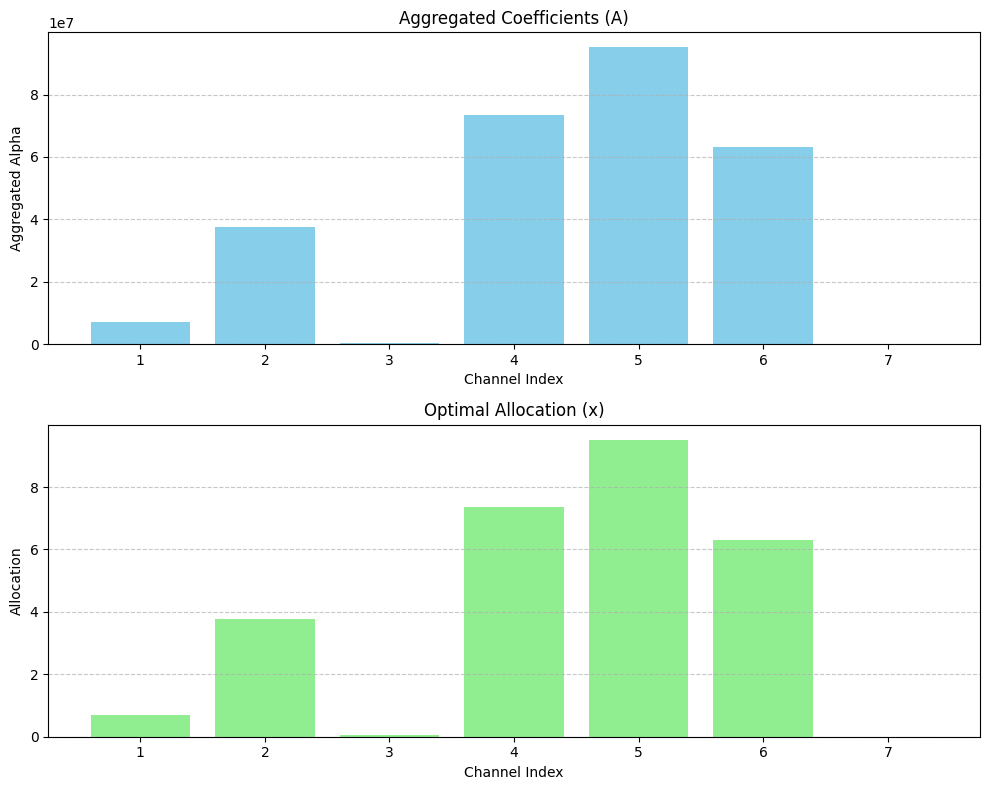

In [17]:
# --- Given Alphas for 5 Categories (each with 7 channels) ---
Camera_alphas = final_g[-1]
GamingHardware_alphas = final_g[1]
GameCDDVD_alphas = final_g[-2]
EntertainmentSmall_alphas = final_g[2]
CameraAccessory_alphas = final_g[0]

# --- Aggregate Alphas Across the 5 Channels ---
# For each channel index (0 to 6), add the corresponding values from each category.

aggregated_alphas = (GamingHardware_alphas +
                     GameCDDVD_alphas +
                     EntertainmentSmall_alphas +
                     CameraAccessory_alphas)

result_final = optimize_allocation(aggregated_alphas)

# --- Display the Results ---
print("\nFinal Optimization Results:")
print("Success:", result_final.success)
print("Message:", result_final.message)
print("Optimal x values:", result_final.x)
print("Sum of x values:", np.sum(result_final.x))
print("Maximum value of the function:", -result_final.fun/1e7)

# --- Detailed Breakdown ---
print("\nDetailed breakdown:")
for i, (A_val, x_val) in enumerate(zip(aggregated_alphas, result_final.x)):
    print(f"x_{i+1}: {x_val:.6f} (Aggregated Coefficient A_{i+1} = {A_val:.2e})")

# --- Visualize the Results ---
try:
    visualize_results(aggregated_alphas, result_final.x)
except Exception as e:
    print("\nVisualization failed:", e)

## Export to JSON

In [19]:
answer = result_final.x
###########
file_path = "./electromart-dashboard copy/electromart-dashboard copy/src/components/src/budget_optimization.json"
json_result = daily_data.to_json(orient='records')
category_revenue = json.dumps(json.loads(json_result), indent=2)
with open(file_path, 'w') as f:
    json.dump(json.loads(json_result), f, indent=2)

print(f"JSON file saved to: {file_path}")

JSON file saved to: ./electromart-dashboard copy/electromart-dashboard copy/src/components/src/budget_optimization.json
